In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
import agent as A
import flipped_agent as FA

In [2]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        return moves, np.vstack(boards)
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return np.copy(self.board), reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [3]:
def reset_graph(seed=42):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [4]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, H3, D_out = 29, 32, 64, 128, 1

actor = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Softmax(dim=0),
)
critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Tanh(),
)

In [8]:
def get_action_and_value(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    with torch.no_grad():
        action = int(torch.multinomial(possible_actions_probs.view(1,-1), 1))
    action_value = possible_actions_probs[action]
    return action, action_value

def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    with torch.no_grad():
        boards = torch.from_numpy(boards).float()
        possible_actions_probs = actor(boards)
        action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(nn, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = nn(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=1):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

Reward:  1


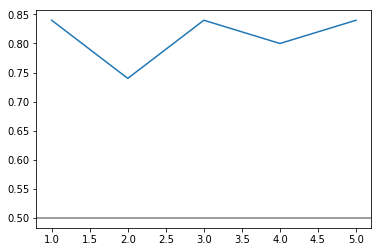

Episode: 250
time per 50 : 3.152080535888672


In [12]:
# Against random

gamma = 0.99
actor_alpha = 0.01
critic_alpha = 0.01
actor_lambda = 0.7
critic_lambda = 0.7
forever = 300

plt_iter = 50
rew = []
rew_plt = []

from time import time
tic = time()

for episode in range(forever):      
    env = backgammon()
    done = False
    I = 1
    step = 1
    actor_Z = [0 for layer in actor.parameters()]
    critic_Z = [0 for layer in critic.parameters()]
    Error = False

    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)

            if len(possible_moves) == 0:
                break
            
            action = epsilon_greedy(critic, possible_boards) # Only use after_state values
            """
            #pi = get_action_value(actor, possible_boards, action)
            action, pi = get_action_and_value(actor, possible_boards) # Using actor
            pi.clamp(min=1e-8) # so that log does not become nan
            log_pi = torch.log(pi) 
            actor.zero_grad()
            log_pi.backward()
            with torch.no_grad():
                for i, param in enumerate(actor.parameters()):
                    actor_Z[i] = actor_lambda * I * actor_Z[i] + param.grad
            """
            action = epsilon_greedy(critic, possible_boards) # Only use after_state values
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
        """
        if not done:
            value = get_state_value(critic, after_state)
            critic.zero_grad()
            value.backward()
            with torch.no_grad():
                for i, param in enumerate(critic.parameters()):
                    critic_Z[i] = critic_lambda * critic_Z[i] + param.grad
        else:
            value = 0
        """
            
        with torch.no_grad():
            # other players move
            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    next_state, reward, done = env.make_move(dice)
                    if done:
                        break
                next_value = get_state_value(critic, next_state)
            else:
                next_value = 0
            """
            #delta = reward + gamma*next_value - value
            if (step>1):
                delta = reward + gamma*value - old_value
            old_value = value
            """

            ###### plot
            if episode%plt_iter == 0:
                if done:
                    clear_output(True)
                    print('Reward: ',reward)
                    rew_plt.append(np.mean(np.equal(rew,1)))
                    rew = []
                    plt.plot(rew_plt)
                    plt.axhline(0.5, color="gray")
                    plt.show()
                    rnd = False
                    print("Episode: {}".format(episode))
                    toc=time()
                    print('time per',plt_iter,':',toc-tic)
                    tic=toc
                    #env.render()
            ######
            """
            if step > 1:
                for j, param in enumerate(critic.parameters()):
                    param += critic_alpha * delta * critic_Z[j]
                #for j, param in enumerate(actor.parameters()):
                #    param += actor_alpha * delta * actor_Z[j]
            """
        I *= gamma
        step += 1
        
    rew.append(reward)
    #actor_alpha *= 0.99
    #critic_alpha *= 0.99

In [ ]:
print(param)

In [ ]:
possible_moves, possible_boards = backgammon().legal_moves(1)
get_action_value(actor, possible_boards)

In [ ]:
env.board

In [ ]:
env.board = FA.flip_board(env.board)
env.board

Reward:  -1


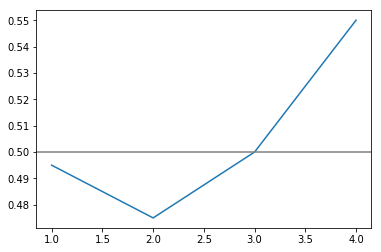

Episode: 800
time per 200 : 21.97265934944153


In [10]:
# Learn / self-play

gamma = 1
actor_alpha = 0.01
critic_alpha = 0.0001
actor_lambda = 0.7
critic_lambda = 0.7
forever = 1000

plt_iter = 200
rew = []
rew_plt = []

from time import time
tic = time()

for episode in range(forever):      
    env = backgammon()
    done = False
    I = 1
    step = 1
    #actor_Z = [0 for layer in actor.parameters()]
    critic_Z1 = [0 for layer in critic.parameters()]
    critic_Z2 = [0 for layer in critic.parameters()]
    Error = False

    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)

            if len(possible_moves) == 0:
                break
            #pi = get_action_value(actor, possible_boards, action)
            #action, pi = get_action_and_value(actor, possible_boards) # Using actor
            #pi.clamp(min=1e-8) # so that log does not become nan
            #log_pi = torch.log(pi) 
            #actor.zero_grad()
            #log_pi.backward()
            action = epsilon_greedy(critic, possible_boards) # Only use after_state values
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
        if not done:
            value1 = get_state_value(critic, after_state)
            critic.zero_grad()
            value1.backward()
        else:
            value1 = 0
        if step > 1:
            with torch.no_grad():
                delta1 = reward + gamma*value1 - old_value1
                for j, param in enumerate(critic.parameters()):
                    param += critic_alpha * delta1 * critic_Z1[j]
                    #critic_Z1[j] = critic_lambda * critic_Z1[j] + param.grad
        with torch.no_grad():
            for j, param in enumerate(critic.parameters()):
                critic_Z1[j] = critic_lambda * critic_Z1[j] + param.grad
        """
        with torch.no_grad():
            for i, param in enumerate(critic.parameters()):
                critic_Z1[i] = critic_lambda * critic_Z1[i] + value1.grad
        """
        
        old_value1 = value1
            
        if not done:
            env.board = FA.flip_board(env.board)
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)

                if len(possible_moves) == 0:
                    break
                #pi = get_action_value(actor, possible_boards, action)
                #action, pi = get_action_and_value(actor, possible_boards) # Using actor
                #pi.clamp(min=1e-8) # so that log does not become nan
                #log_pi = torch.log(pi) 
                #actor.zero_grad()
                #log_pi.backward()
                action = epsilon_greedy(critic, possible_boards) # Only use after_state values
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break
            if not done:
                value2 = get_state_value(critic, after_state)
                critic.zero_grad()
                value2.backward()
            else:
                value2 = 0
            if step > 1:
                with torch.no_grad():
                    delta2 = reward + gamma*value2 - old_value2
                    for j, param in enumerate(critic.parameters()):
                        param += critic_alpha * delta2 * critic_Z2[j]
            with torch.no_grad():
                for j, param in enumerate(critic.parameters()):
                    critic_Z2[j] = critic_lambda * critic_Z2[j] + param.grad
            old_value2 = value2
            
            reward = -1*reward
            env.board = FA.flip_board(env.board)

        ###### plot
        if episode%plt_iter == 0:
            if done:
                clear_output(True)
                print('Reward: ',reward)
                rew_plt.append(np.mean(np.equal(rew,1)))
                rew = []
                plt.plot(rew_plt)
                plt.axhline(0.5, color="gray")
                plt.show()
                rnd = False
                print("Episode: {}".format(episode))
                toc=time()
                print('time per',plt_iter,':',toc-tic)
                tic=toc
                #env.render()
        ######       
        #I *= gamma
        step += 1
    # Game is over, update for loser
    if (reward == 1):
        with torch.no_grad():
            delta2 = -1 - old_value2
            for j, param in enumerate(critic.parameters()):
                param += critic_alpha * delta2 * critic_Z2[j]
    else:
        with torch.no_grad():
            delta1 = -1 - old_value1
            for j, param in enumerate(critic.parameters()):
                param += critic_alpha * delta1 * critic_Z1[j]
        
    rew.append(reward)
    #actor_alpha *= 0.99
    #critic_alpha *= 0.99